# Female headed households in South Africa

In  this notebook we will work on the data provided by Zindi during the  competition **Women in Big Data South Africa - Women-Headed Households in South Africa**. We will create our own model to find out which features have an impact on the income of a female-headed household. 

In [46]:
# import packages 
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import boxcox
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 6]

# Loading the data
We will load the provided csv file from Zindi. In this notebook we will only work with the train data (Train.csv), as the test data (Test.csv) has no target variable and we can't evaluate our predictions. Additionally we will also load the file with the descriptions of the features (descriptions.csv).

In [4]:
# import data
df = pd.read_csv('data/Train.csv')
df.head()

,ward,total_households,total_individuals,target,dw_00,dw_01,dw_02,dw_03,dw_04,dw_05,...,pw_03,pw_04,pw_05,pw_06,pw_07,pw_08,ADM4_PCODE,lat,lon,NL
0,41601001: Ward 1,1674.45058,5888.20750,16.773757,0.933841,0.000846,0.005490,0.000676,0.000000,0.001372,...,0.002848,0.007537,0.000000,0.012928,0,0,ZA4161001,-29.682270,24.734743,0.292039
1,41601002: Ward 2,1736.99230,6735.33812,21.496661,0.696940,0.001253,0.004402,0.000000,0.002301,0.001323,...,0.014566,0.057127,0.019092,0.004131,0,0,ZA4161002,-29.119311,24.757737,3.207775
2,41601003: Ward 3,2403.57591,7273.04995,10.931425,0.810545,0.004517,0.008891,0.003986,0.007735,0.000956,...,0.057560,0.010358,0.001421,0.040881,0,0,ZA4161003,-29.142276,25.094093,0.000000
3,41601004: Ward 4,1740.78737,5734.49046,23.119257,0.659914,0.000000,0.006129,0.000000,0.000813,0.037245,...,0.000000,0.000669,0.000000,0.005011,0,0,ZA4161004,-29.372052,24.942867,2.038778
4,41601005: Ward 5,1730.51451,6657.23835,13.652252,0.950575,0.000655,0.001473,0.000598,0.006999,0.000818,...,0.004859,0.001290,0.000673,0.017629,0,0,ZA4161005,-29.409381,25.290165,0.000000


In [5]:
# get some general information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2822 entries, 0 to 2821
Data columns (total 63 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ward               2822 non-null   object 
 1   total_households   2822 non-null   float64
 2   total_individuals  2822 non-null   float64
 3   target             2822 non-null   float64
 4   dw_00              2822 non-null   float64
 5   dw_01              2822 non-null   float64
 6   dw_02              2822 non-null   float64
 7   dw_03              2822 non-null   float64
 8   dw_04              2822 non-null   float64
 9   dw_05              2822 non-null   float64
 10  dw_06              2822 non-null   float64
 11  dw_07              2822 non-null   float64
 12  dw_08              2822 non-null   float64
 13  dw_09              2822 non-null   float64
 14  dw_10              2822 non-null   float64
 15  dw_11              2822 non-null   float64
 16  dw_12              2822 

In [51]:
# get a statistical overview of the dataframe
df.describe()

,target,dw_00,dw_01,dw_02,dw_03,dw_04,dw_05,dw_06,dw_07,dw_08,...,pg_03,pg_04,lgt_00,pw_00,pw_01,pw_02,pw_03,pw_04,pw_05,pw_06
count,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,...,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000
mean,24.507554,0.712196,0.092616,0.032043,0.006057,0.008665,0.006289,0.022375,0.039296,0.064586,...,0.074429,0.003693,0.836432,0.359691,0.329684,0.127555,0.041589,0.019655,0.011008,0.110818
std,10.294387,0.214035,0.182852,0.080253,0.019374,0.030697,0.024606,0.037127,0.057889,0.109802,...,0.169270,0.010813,0.203143,0.304472,0.236642,0.156400,0.057331,0.032926,0.023672,0.185401
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.001692,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,16.751556,0.594212,0.002895,0.002407,0.000000,0.000000,0.000000,0.002716,0.004716,0.002888,...,0.000451,0.000664,0.796471,0.087638,0.111282,0.008673,0.002099,0.000715,0.000159,0.005217
50%,24.156670,0.766841,0.010425,0.005762,0.000807,0.000607,0.000865,0.008639,0.016295,0.014991,...,0.001208,0.001696,0.914060,0.277999,0.302130,0.069065,0.016496,0.005164,0.001459,0.025165
75%,32.226553,0.881708,0.068209,0.027913,0.002538,0.002225,0.003027,0.025218,0.048730,0.074748,...,0.041841,0.004126,0.964334,0.582946,0.508771,0.183384,0.058626,0.025055,0.009432,0.116638
max,55.528423,0.994962,0.931490,0.951806,0.264239,0.392085,0.435912,0.412936,0.455815,0.798479,...,0.940563,0.367842,1.000000,0.995907,0.937595,1.000000,0.327393,0.306787,0.228261,0.961523


In [6]:
# check for null values
df.isnull().sum().sort_values(ascending=False)

ward      0
pg_03     0
lan_05    0
lan_06    0
lan_07    0
         ..
car_01    0
lln_00    0
lln_01    0
lan_00    0
NL        0
Length: 63, dtype: int64

In [8]:
# check for columns with single values
df.nunique().sort_values().head(10)

dw_13        1
lan_13       1
dw_12        1
pw_08        1
pw_07        1
lan_14    1459
dw_10     1695
dw_04     1799
dw_05     1952
dw_03     2094
dtype: int64

In [9]:
# print the columns with single values for a visual check
df[['dw_13', 'lan_13', 'dw_12', 'pw_08', 'pw_07']]

,dw_13,lan_13,dw_12,pw_08,pw_07
0,0,0,0,0,0
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,0
...,...,...,...,...,...
2817,0,0,0,0,0
2818,0,0,0,0,0
2819,0,0,0,0,0
2820,0,0,0,0,0


The columns ['dw_13', 'lan_13', 'dw_12', 'pw_08', 'pw_07'] have only 0 in them --> we could drop these features, Also we can drop some other non-relevant features (ward, coordinates, features not given in percentage, Nightlight).

In [10]:
# drop the non-numerical features
df = df.drop(['ward', 'ADM4_PCODE'], axis=1)

# drop non-percentage features: (total_households, total_individuals, lat, lon, NL and all-Zero values)
df = df.drop(['total_households', 'total_individuals', 'lat', 'lon', 'NL', 'dw_13', 'lan_13', 'dw_12', 'pw_08', 'pw_07'], axis=1)

In [11]:
# check new dataframe after dropping the features with only 0 in them
df.shape

(2822, 51)

In [12]:
# load the description file and have a look at them
var_desc = pd.read_csv('data/variable_descriptions.csv')
pd.set_option('display.max_colwidth', 200) # So that we can see the full descriptions
var_desc

,Column,Description,Unnamed: 2,Unnamed: 3
0,dw_00,Percentage of dwellings of type: House or brick/concrete block structure on a separate stand or yard or on a farm,NaN,NaN
1,dw_01,Percentage of dwellings of type: Traditional dwelling/hut/structure made of traditional materials,NaN,NaN
2,dw_02,Percentage of dwellings of type: Flat or apartment in a block of flats,NaN,NaN
3,dw_03,Percentage of dwellings of type: Cluster house in complex,NaN,NaN
4,dw_04,Percentage of dwellings of type: Townhouse (semi-detached house in a complex),NaN,NaN
5,dw_05,Percentage of dwellings of type: Semi-detached house,NaN,NaN
6,dw_06,Percentage of dwellings of type: House/flat/room in backyard,NaN,NaN
7,dw_07,Percentage of dwellings of type: Informal dwelling (shack,in backyard),NaN
8,dw_08,Percentage of dwellings of type: Informal dwelling (shack,not in backyard,e.g. in an informal/squatter settlement or on a farm)
9,dw_09,Percentage of dwellings of type: Room/flatlet on a property or larger dwelling/servants quarters/granny flat,NaN,NaN


# Quick EDA
Before we dive into modelling, let's take a quick look at the data and see what we have to work with. 

## Looking at the target variable
The purpose of this project is to predict the percentage of households in a ward that are woman-headed and have an annual household income of <R19,600. To put that in context, that's less than 250USD per month. 

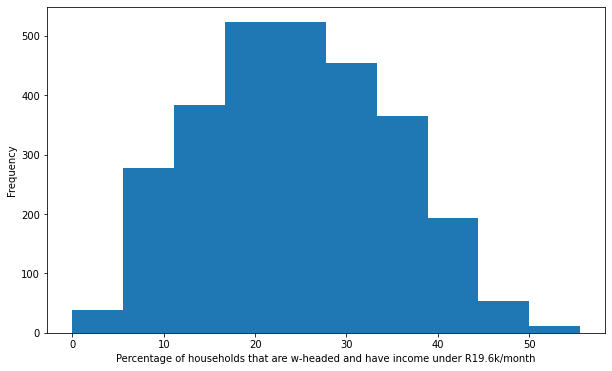

In [13]:
# Plot the distribution
ax = df['target'].plot(kind='hist')
plt.xlabel('Percentage of households that are w-headed and have income under R19.6k/month');

# Baseline Model

As a starter we will create a baseline model to get an idea how a more complex model could look like.

In [21]:
# Get a very reduced dataframe for the baseline model
# we choose the highly correlated variable school attendance = yes (psa_00) for our baseline model 
df_base = df[['psa_00', 'target']]
df_base.head()

,psa_00,target
0,0.260191,16.773757
1,0.290228,21.496661
2,0.186435,10.931425
3,0.281229,23.119257
4,0.196687,13.652252


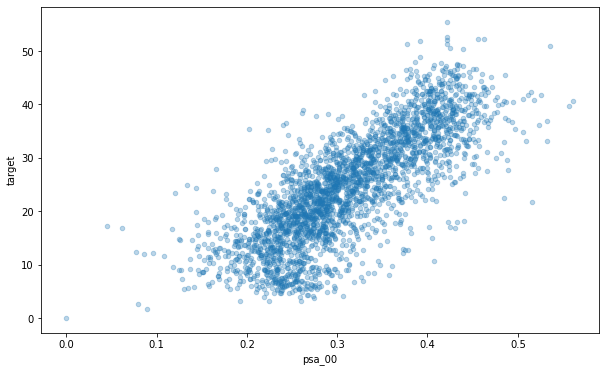

In [22]:
# plot the baseline model
df_base.plot(x='psa_00', y='target', kind='scatter', alpha=0.3);

## Modelling the baseline model
Before we go deeper, we will build a quick model FIRST, to see a baseline to compare to. So, in this section we'll try a simple linear model based on only one highly correlated feature. 

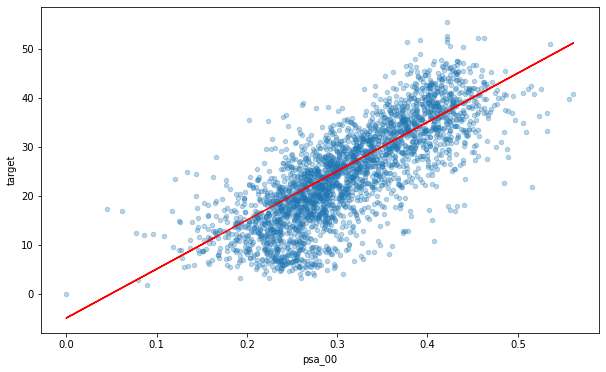

In [23]:
# Modelling by hand: regression line formula

# as we can see from the scatter plot, a line would run through (0 | -5), we only need a slope
# points would be: (0.2 | 10), (0.3 | 20) --> the slope is 100
# y = 100 * x -5

# put this line in the plot:
x = df_base['psa_00']
y = 100 * x - 5

df_base.plot(x='psa_00', y='target', kind='scatter', alpha=0.3)
plt.plot(x, y, '-r', label='y = 100 * x')
plt.show();

### Evaluating Predictions

We can evaluate our predictions with the "R-Squared Score", which is a measure of how well our model explains the variation in the target variable. The closer to 1, the better. 

In [24]:
# try to calculate RMSE for this line:
from sklearn.metrics import mean_squared_error
import math

mse = mean_squared_error(df_base['target'], y)

rmse = math.sqrt(mse)

print("RMSE of baseline model:", round(rmse, 2))
print("Error in % of baseline model:", round((rmse/np.average(y))*100, 2))
print("Mean of the target:", round(np.average(y), 2))
print("Standard deviation of the target:", round(np.std(y), 2))

RMSE of baseline model: 6.62
Error in % of baseline model: 25.35
Mean of the target: 26.13
Standard deviation of the target: 7.66


# Complex model

In order to model the complex model we consider all the remaining 51 features,

In [ ]:
# Train test split with same random seed
# Defining X and y
features = df.columns.tolist()
features.remove('target')
X = df[features]
y = df.target

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=150, shuffle=True)

# Check the shape of the data sets
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

X_train: (2116, 50)
y_train: (2116,)
X_test: (706, 50)
y_test: (706,)


In [ ]:
# train model
lr = LinearRegression()
lr.fit(X_train,y_train)

LinearRegression()

In [ ]:
# predict target values
y_pred = lr.predict(X_test)

In [ ]:
# check error for predictions
from sklearn.metrics import r2_score
score = r2_score(y_test, y_pred)
print("r2 score is ", round(score, 2))
print("mean_sqrd_error is:", round(mean_squared_error(y_test, y_pred), 2))
print("root_mean_squared error is:", round(np.sqrt(mean_squared_error(y_test, y_pred)), 2))

r2 score is  0.85
mean_sqrd_error is: 15.72
root_mean_squared error is: 3.96


# Final Model

After trying a first very basic Baseline model and then the complex model, we now make our model simpler by reducing the features. The features were chosen after checking the correlations.

# Looking at a few interesting correlations

In [ ]:
# Strong +ve correlations
df.corr()['target'].sort_values(ascending=False).head(10)

target    1.000000
psa_00    0.782472
car_01    0.702831
stv_01    0.664181
lln_01    0.637835
pg_00     0.613346
pw_06     0.470676
dw_01     0.458206
pw_02     0.442441
pw_03     0.440941
Name: target, dtype: float64

In [18]:
# And negative correlations
df.corr()['target'].sort_values().head(10)

pw_00    -0.754536
psa_01   -0.707506
car_00   -0.702831
stv_00   -0.664181
lln_00   -0.637835
pg_03    -0.583908
lan_00   -0.507942
lan_01   -0.438704
dw_04    -0.385533
dw_03    -0.338137
Name: target, dtype: float64

In [19]:
# create a list of positive and negative correlated features above a treshold of |0.5|
# negatively correlated features (- 0.5 threshold)
list1 = list((df.corr()['target'].sort_values().head(8)).index)
# positively correlated features (+ 0.5 threshold)
list2 = list((df.corr()['target'].sort_values(ascending=False).head(6)).index)
# list2 = list((df.corr()['target'].sort_values(ascending=False).head(6)).index)
# combine both lists
corr_feature_list = list1 + list2
corr_feature_list

['pw_00',
 'psa_01',
 'car_00',
 'stv_00',
 'lln_00',
 'pg_03',
 'lan_00',
 'lan_01',
 'target',
 'psa_00',
 'car_01',
 'stv_01',
 'lln_01',
 'pg_00']

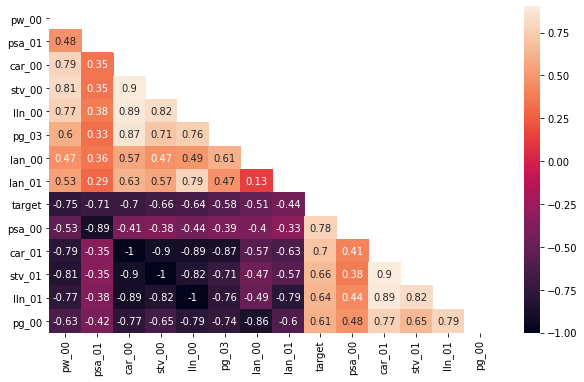

In [20]:
# plot the list of highly correlated features
corr = df[corr_feature_list].corr()
matrix = np.triu(corr)
sns.heatmap(corr, annot=True, mask=matrix);

Car00 and Car01 / Stv00 and Stv01 / Lln00 and Lln01 perfectly correlated (- 1) --> we can remove each one of them

In [28]:
# select features with high correlations
#feature_list = ['pw_00', 'pw_01', 'psa_00', 'psa_01', 'car_00', 'lln_00', 'stv_00', 'pg_00', 'pg_03', 'lan_00', 'lan_01', 'target']
df_final = df[corr_feature_list]
df_final.drop(['car_01', 'stv_01', 'lln_01'], axis=1, inplace=True)
df_final.head()

/Users/ravi/neuefische/urban-eureka/.venv/lib/python3.9/site-packages/pandas/core/frame.py:4305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,pw_00,psa_01,car_00,stv_00,lln_00,pg_03,lan_00,lan_01,target,psa_00,pg_00
0,0.742692,0.607898,0.273727,0.283468,0.118825,0.072996,0.832913,0.012336,16.773757,0.260191,0.357455
1,0.309294,0.549788,0.144638,0.103641,0.066903,0.015835,0.879655,0.008445,21.496661,0.290228,0.698428
2,0.323393,0.677005,0.272220,0.165772,0.100009,0.167494,0.565546,0.015991,10.931425,0.186435,0.672452
3,0.677437,0.593281,0.127875,0.087768,0.029155,0.000956,0.743812,0.006530,23.119257,0.281229,0.728014
4,0.771106,0.517578,0.404507,0.345975,0.133552,0.106953,0.422623,0.014352,13.652252,0.196687,0.753491


## Transformation

In [29]:
# write function to transform features with boxcox
def convert_zeros(x):
    '''
    function to convert zeros to a postive number 
    so that it can be transformed with the boxcox'''
    if x == 0.0:
        return 0.0000001
    else :
        return x

In [25]:
# check for 0 before and convert them
print (df['pw_00'].isin([0]).sum())
print(df['pw_00'].apply(convert_zeros).isin([0]).sum())

1
0


/var/folders/4q/jchndf6x7rv99dbr5nzt756h0000gn/T/ipykernel_4885/1125557172.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final[col] = df_final[col].apply(convert_zeros)
/var/folders/4q/jchndf6x7rv99dbr5nzt756h0000gn/T/ipykernel_4885/1125557172.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final[col] = df_final[col].apply(convert_zeros)
/var/folders/4q/jchndf6x7rv99dbr5nzt756h0000gn/T/ipykernel_4885/1125557172.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

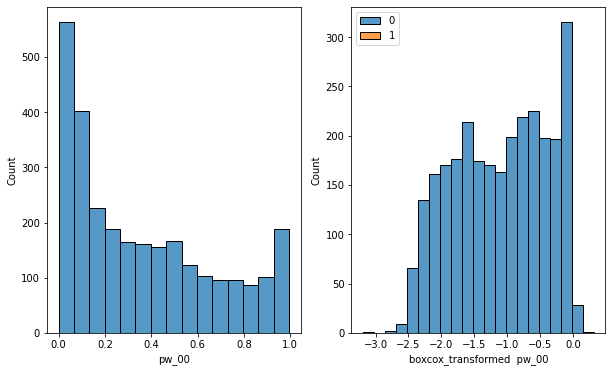

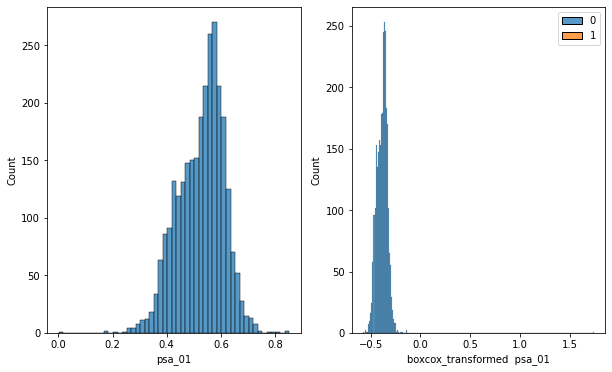

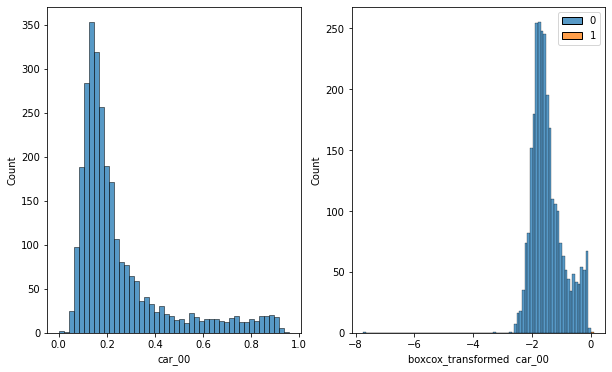

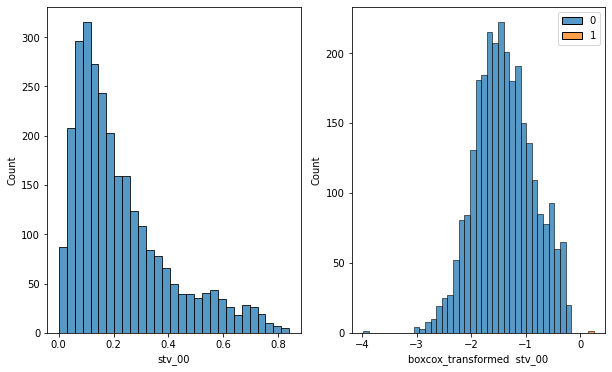

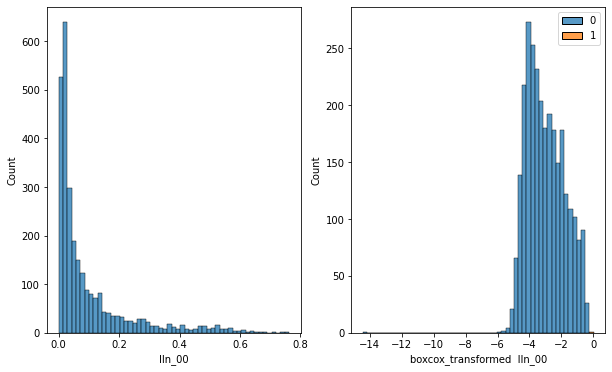

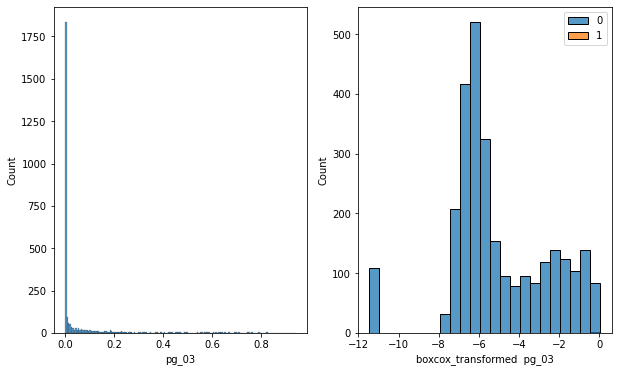

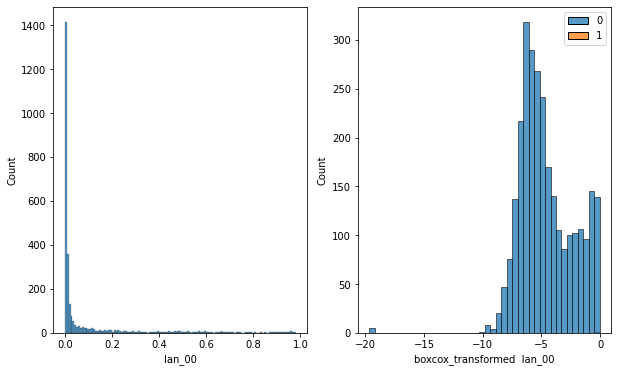

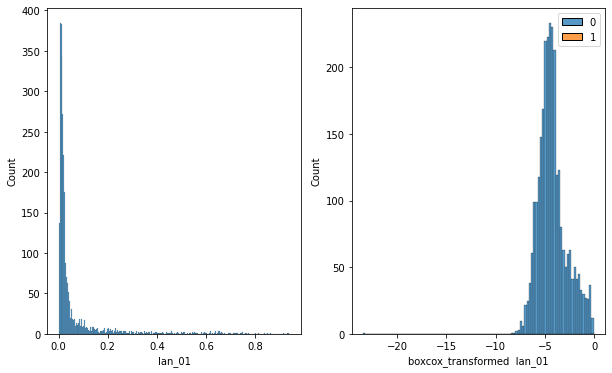

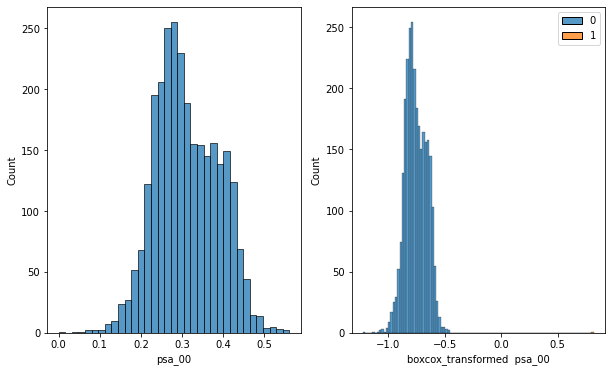

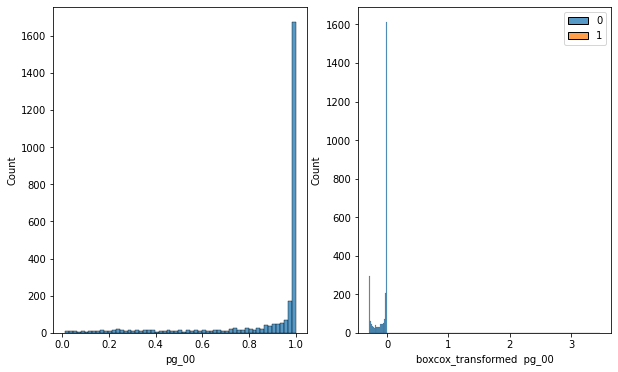

In [31]:
# plot transformed features
for col in df_final.columns:
    if col != 'target':
        fig, axes = plt.subplots(1,2)
        df_final[col] = df_final[col].apply(convert_zeros)
        sns.histplot(df_final[col], ax=axes[0])
        plt.xlabel(col)
        sns.histplot(boxcox(df_final[col]), ax=axes[1])
        plt.xlabel('boxcox_transformed  ' + col)

In [33]:
# apply the boxcox transformation on 

for col in df_final.columns:
    if col != 'target' and  col != 'psa_00' and  col != 'psa_01' and col != 'car_00' and col != 'pg_00':
        #df_final[col] = df_final[col].apply(convert_zeros)
        df_final[col] = boxcox(df_final[col])[0].reshape(-1,1);

/var/folders/4q/jchndf6x7rv99dbr5nzt756h0000gn/T/ipykernel_4885/1705818497.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final[col] = boxcox(df_final[col])[0].reshape(-1,1);


In [34]:
# check data after log transformation
df_final.head()

,pw_00,psa_01,car_00,stv_00,lln_00,pg_03,lan_00,lan_01,target,psa_00,pg_00
0,-0.284113,0.607898,0.273727,-1.083683,-2.098567,-2.468668,-0.183226,-4.848608,16.773757,0.260191,0.357455
1,-0.982978,0.549788,0.144638,-1.736930,-2.653801,-3.780784,-0.128422,-5.312215,21.496661,0.290228,0.698428
2,-0.951828,0.677005,0.272220,-1.452065,-2.265679,-1.716657,-0.573863,-4.535601,10.931425,0.186435,0.672452
3,-0.366754,0.593281,0.127875,-1.830113,-3.448817,-5.967212,-0.297017,-5.631192,23.119257,0.281229,0.728014
4,-0.249689,0.517578,0.404507,-0.933968,-1.985076,-2.126300,-0.870200,-4.665611,13.652252,0.196687,0.753491


In [40]:
# do the cross validation manually
from sklearn.model_selection import KFold

# Using this to test a model on 5 different splits
kf = KFold(n_splits=5, shuffle=False)

ycol = 'target'
in_cols = df_final.drop('target', axis=1).columns

scores = []
for train, test in kf.split(df_final):
  lr = LinearRegression()
  lr.fit(df_final[in_cols].iloc[train], df_final[ycol].iloc[train])
  rmse = np.sqrt(mean_squared_error(df_final[ycol].iloc[test], lr.predict(df_final[in_cols].iloc[test])))
  scores.append(rmse)
  print(rmse)

print("Average score in 5-fold CV:", np.mean(scores))

4.36195280510332
4.271922650748622
4.963199559237126
4.648755336977956
5.7754930505702875
Average score in 5-fold CV: 4.804264680527462


In [41]:
# Train test split with same random seed
# Defining X and y
features = df_final.columns.tolist()
features.remove('target')
X = df_final[features]
y = df_final.target

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=150, shuffle=True)

# Check the shape of the data sets
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

X_train: (2116, 10)
y_train: (2116,)
X_test: (706, 10)
y_test: (706,)


In [54]:
lr = LinearRegression()
lr.fit(X_train,y_train)

# predict target values
y_pred = lr.predict(X_test)

In [55]:
# check error for predictions
from sklearn.metrics import r2_score
score = r2_score(y_test, y_pred)
print("r2 score is ", round(score, 2))
print("mean_sqrd_error is:", round(mean_squared_error(y_test, y_pred), 2))
print("root_mean_squared error is:", round(np.sqrt(mean_squared_error(y_test, y_pred)), 2))

r2 score is  0.82
mean_sqrd_error is: 18.99
root_mean_squared error is: 4.36


/Users/ravi/neuefische/urban-eureka/.venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


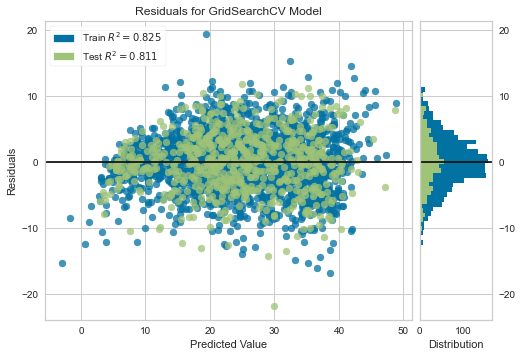

<AxesSubplot:title={'center':'Residuals for GridSearchCV Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [56]:
# Plot the errors
from yellowbrick.regressor import ResidualsPlot

#visualizer = ResidualsPlot(gs, hist=False, qqplot=True)
visualizer = ResidualsPlot(gs)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()